In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 24 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.1 * u.Unit("TeV-1"),
    alpha = 1,
    
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 86400.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 537 
    Total predicted counts          : nan
    Total background counts         : 545.07

    Effective area min              : 8.47e+04 m2
    Effective area max              : 5.61e+06 m2

    Livetime                        : 8.64e+04 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 3143 
    Total predicted counts          : 3174.69
    Total off counts                : 2716.00

    Total background counts         : 543.20

    Effective area min              : 8.47e+04 m2
    Effective area max              : 5.61e+06 m2

    Livetime                        : 2.40e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [18]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 1.87 s, sys: 8.11 ms, total: 1.88 s
Wall time: 1.88 s


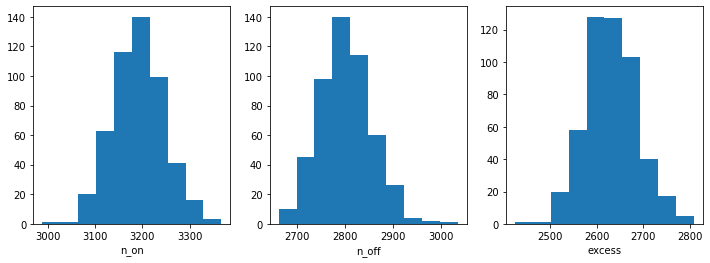

In [19]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("n_on")
axes[1].hist(n_off)
axes[1].set_xlabel("n_off")
axes[2].hist(excess)
axes[2].set_xlabel("excess");

In [20]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 1min 6s, sys: 283 ms, total: 1min 6s
Wall time: 1min 6s


In [21]:
results

[{'index': 2.091080426330053,
  'amplitude': 1.4377447903797829e-12,
  'lambda_': 0.16757515826803393},
 {'index': 2.1992641499270347,
  'amplitude': 1.2849593831269274e-12,
  'lambda_': 0.1236135138027805},
 {'index': 2.3036580231744126,
  'amplitude': 1.1935679451614676e-12,
  'lambda_': 0.06204487933553751},
 {'index': 2.2233557178934036,
  'amplitude': 1.2779316583009208e-12,
  'lambda_': 0.10978114235385737},
 {'index': 2.295201106330157,
  'amplitude': 1.2848840761015315e-12,
  'lambda_': 0.07844071966919769},
 {'index': 2.242598388789023,
  'amplitude': 1.2381242092457172e-12,
  'lambda_': 0.08056671417079225},
 {'index': 2.284883506899335,
  'amplitude': 1.264080751317502e-12,
  'lambda_': 0.07826527688375773},
 {'index': 2.2312615554808337,
  'amplitude': 1.2354591409403203e-12,
  'lambda_': 0.08456783863367254},
 {'index': 2.116971037675932,
  'amplitude': 1.3959591324522044e-12,
  'lambda_': 0.1593256075398594},
 {'index': 2.2091386949772724,
  'amplitude': 1.273745857087819

index: 2.2193434886524748 += 0.060889263577483733


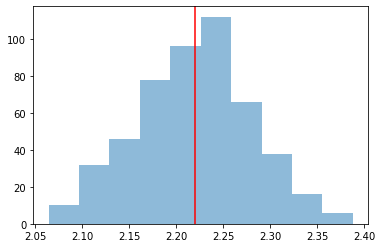

In [22]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2919864054260152e-12 += 6.42444051007483e-14


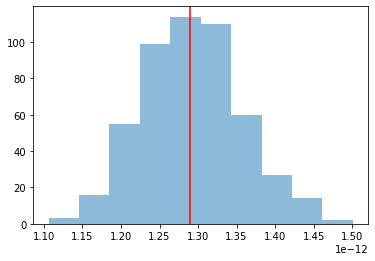

In [23]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.10107777411442592 += 0.03054590082506155


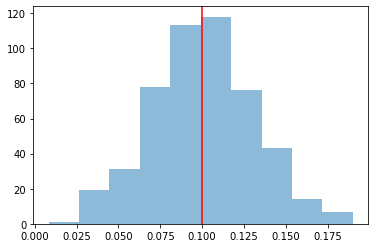

In [24]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")